# Terrain Data Analysis
Analyzing DEM and RGB GeoTIFF files for Isaac Sim terrain rendering

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# File paths
dem_path = "/home/jet/drone-interceptor-sim/data/processed/dem_utm10.tif"
rgb_path = "/home/jet/drone-interceptor-sim/data/processed/rgb_aligned.tif"

print("File paths:")
print(f"DEM: {Path(dem_path).exists()} - {dem_path}")
print(f"RGB: {Path(rgb_path).exists()} - {rgb_path}")

File paths:
DEM: True - /home/jet/drone-interceptor-sim/data/processed/dem_utm10.tif
RGB: True - /home/jet/drone-interceptor-sim/data/processed/rgb_aligned.tif


## 1. DEM Analysis

In [ ]:
# Read DEM
with rasterio.open(dem_path) as dem:
    elevation = dem.read(1)
    dem_meta = dem.meta
    
print("DEM Metadata:")
print(f"  Shape: {elevation.shape}")
print(f"  Data type: {elevation.dtype}")
print(f"  CRS: {dem_meta['crs']}")
print(f"  Transform: {dem_meta['transform']}")
print(f"\nElevation Statistics:")
print(f"  Min: {elevation.min():.2f} m")
print(f"  Max: {elevation.max():.2f} m")
print(f"  Mean: {elevation.mean():.2f} m")
print(f"  Std: {elevation.std():.2f} m")

# Plot DEM
plt.figure(figsize=(10, 8))
plt.imshow(elevation, cmap='terrain')
plt.colorbar(label='Elevation (m)')
plt.title('Digital Elevation Model')
plt.axis('off')
plt.tight_layout()
plt.show()

## 2. RGB Data Analysis

In [2]:
# Read RGB
with rasterio.open(rgb_path) as rgb:
    rgb_meta = rgb.meta
    print("RGB Metadata:")
    print(f"  Bands: {rgb.count}")
    print(f"  Shape: {rgb.height} x {rgb.width}")
    print(f"  Data type: {rgb.dtypes[0]}")
    print(f"  CRS: {rgb_meta['crs']}")
    
    # Read individual bands
    band1 = rgb.read(1)
    band2 = rgb.read(2)
    band3 = rgb.read(3)
    
    print(f"\nBand Statistics:")
    for i, band in enumerate([band1, band2, band3], 1):
        print(f"  Band {i}:")
        print(f"    Min: {band.min()}")
        print(f"    Max: {band.max()}")
        print(f"    Mean: {band.mean():.2f}")
        print(f"    Unique values: {len(np.unique(band))}")
    
    # Stack into RGB image
    rgb_image = np.dstack([band1, band2, band3])

RGB Metadata:
  Bands: 3
  Shape: 91 x 94
  Data type: uint8
  CRS: EPSG:32610

Band Statistics:
  Band 1:
    Min: 0
    Max: 209
    Mean: 40.12
    Unique values: 157
  Band 2:
    Min: 0
    Max: 206
    Mean: 35.94
    Unique values: 150
  Band 3:
    Min: 0
    Max: 207
    Mean: 29.94
    Unique values: 153


## 3. RGB Visualization - Different Normalizations

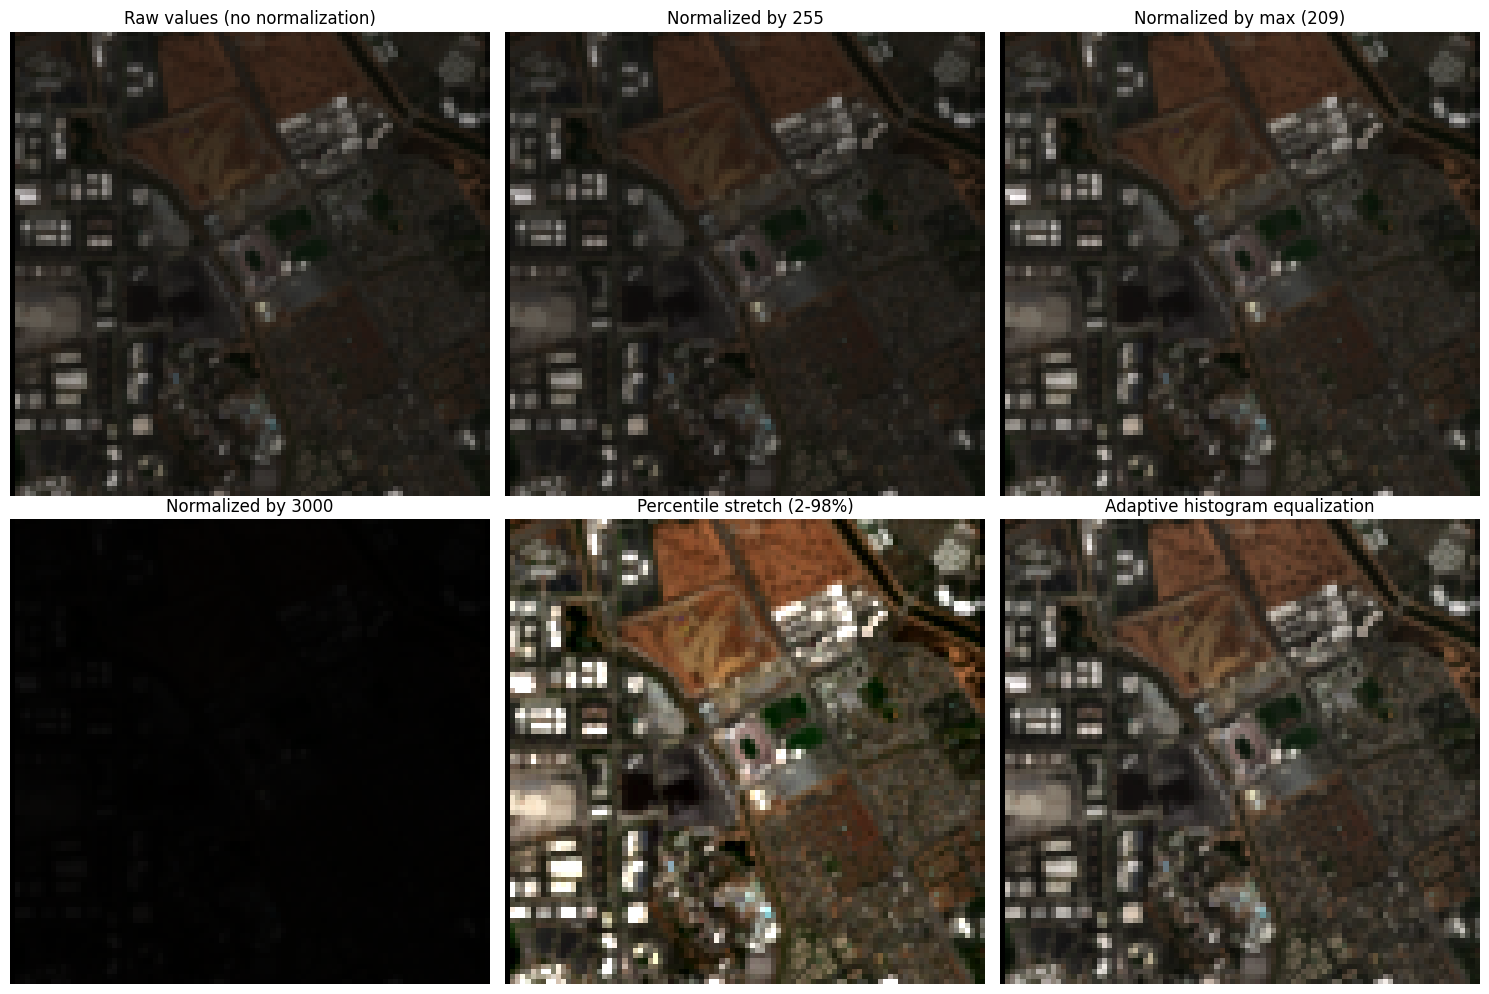


Which visualization looks best? This will tell us the correct normalization to use.


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original (no normalization)
axes[0, 0].imshow(rgb_image.astype(int))
axes[0, 0].set_title('Raw values (no normalization)')
axes[0, 0].axis('off')

# Normalize by 255
rgb_255 = np.clip(rgb_image / 255.0, 0, 1)
axes[0, 1].imshow(rgb_255)
axes[0, 1].set_title('Normalized by 255')
axes[0, 1].axis('off')

# Normalize by max value
rgb_max = rgb_image / rgb_image.max()
axes[0, 2].imshow(rgb_max)
axes[0, 2].set_title(f'Normalized by max ({rgb_image.max():.0f})')
axes[0, 2].axis('off')

# Normalize by 3000 (satellite data typical)
rgb_3000 = np.clip(rgb_image / 3000.0, 0, 1)
axes[1, 0].imshow(rgb_3000)
axes[1, 0].set_title('Normalized by 3000')
axes[1, 0].axis('off')

# Auto-contrast (percentile stretch)
p2, p98 = np.percentile(rgb_image, (2, 98))
rgb_stretch = np.clip((rgb_image - p2) / (p98 - p2), 0, 1)
axes[1, 1].imshow(rgb_stretch)
axes[1, 1].set_title('Percentile stretch (2-98%)')
axes[1, 1].axis('off')

# Histogram equalization
from skimage import exposure
rgb_eq = exposure.equalize_adapthist(rgb_image / rgb_image.max())
axes[1, 2].imshow(rgb_eq)
axes[1, 2].set_title('Adaptive histogram equalization')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nWhich visualization looks best? This will tell us the correct normalization to use.")

## 4. Histogram Analysis

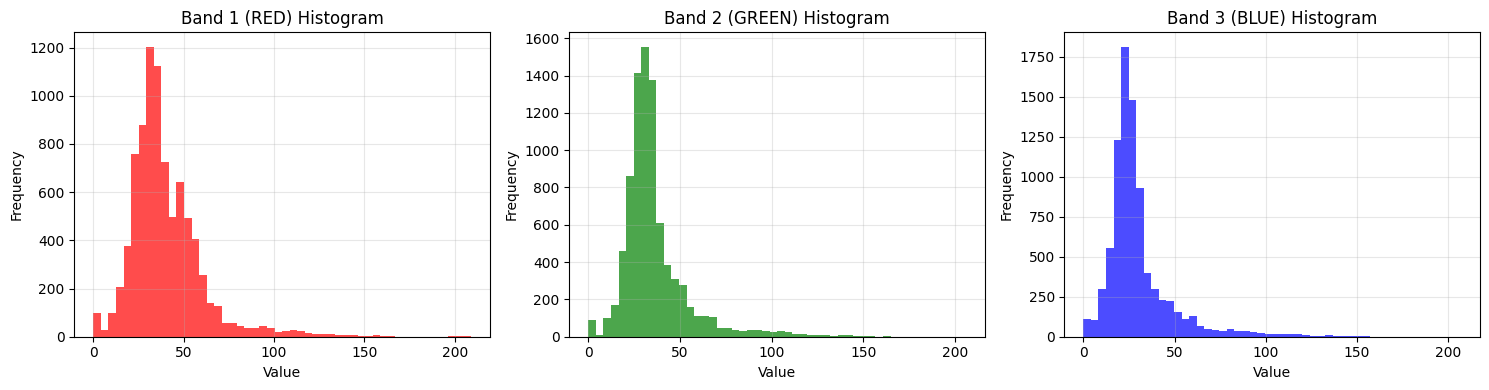

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

colors = ['red', 'green', 'blue']
bands = [band1, band2, band3]

for i, (band, color) in enumerate(zip(bands, colors)):
    axes[i].hist(band.flatten(), bins=50, color=color, alpha=0.7)
    axes[i].set_title(f'Band {i+1} ({color.upper()}) Histogram')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Check if DEM and RGB are aligned

In [6]:
print("Alignment Check:")
print(f"  DEM shape: {elevation.shape}")
print(f"  RGB shape: {rgb_image.shape[:2]}")
print(f"  Shapes match: {elevation.shape == rgb_image.shape[:2]}")

# Side by side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.imshow(elevation, cmap='terrain')
ax1.set_title('DEM')
ax1.axis('off')

# Use best normalization from above
rgb_display = np.clip(rgb_image / rgb_image.max(), 0, 1)
ax2.imshow(rgb_display)
ax2.set_title('RGB (normalized by max)')
ax2.axis('off')

plt.tight_layout()
plt.show()

Alignment Check:


NameError: name 'elevation' is not defined

## 6. Save Enhanced RGB for Isaac Sim

✅ Enhanced RGB saved to: /home/jet/drone-interceptor-sim/data/processed/rgb_enhanced.png
   Size: (94, 91)
   Mode: RGB


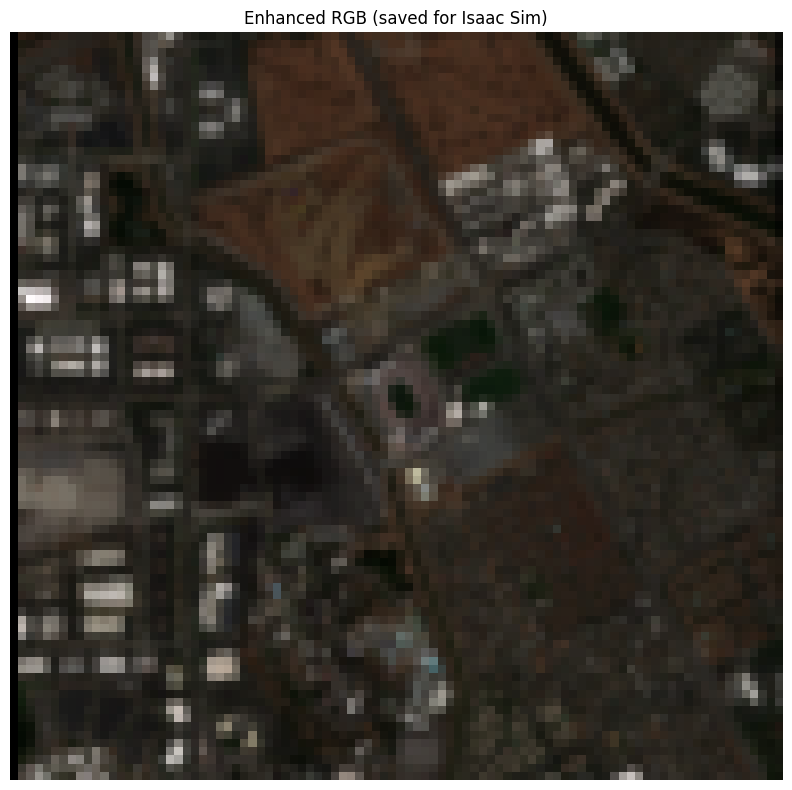

In [7]:
from PIL import Image

# Based on the best visualization above, choose normalization
# Option 1: Normalize by max
rgb_normalized = np.clip(rgb_image / rgb_image.max(), 0, 1)

# Option 2: Percentile stretch (often best for satellite data)
# p2, p98 = np.percentile(rgb_image, (2, 98))
# rgb_normalized = np.clip((rgb_image - p2) / (p98 - p2), 0, 1)

# Convert to 8-bit and save
rgb_uint8 = (rgb_normalized * 255).astype(np.uint8)
img = Image.fromarray(rgb_uint8)

output_path = "/home/jet/drone-interceptor-sim/data/processed/rgb_enhanced.png"
img.save(output_path)

print(f"✅ Enhanced RGB saved to: {output_path}")
print(f"   Size: {img.size}")
print(f"   Mode: {img.mode}")

# Display it
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Enhanced RGB (saved for Isaac Sim)')
plt.axis('off')
plt.tight_layout()
plt.show()